## Example: CLD on Sleep and Depressive symptoms
In our first example, we will implement a system dynamics model (SDM) analysis of a causal loop diagram (CLD) published as an example in the Education Corner article by Uleman et al (2024) doi: ...
This CLD focuses on the feedback loops between sleep and depressive symptoms in young adults.

In Kumu, the diagram looks as follows:

<img src="Kumu/Sleep CLD.jpg" alt="drawing" width="800"/>

To analyze this CLD, we will first run several initialization steps and import the Kumu file (which can be exported from the live Kumu page). Two adjustments are needed to this Kumu file. Firstly, in the 'Elements' sheet, the 'Type' column should specify for each variable whether they are an auxiliary, stock, or constant (see the manuscript for suggestions on how to select between these different variable types). Secondly, if Interaction terms have been identified in the system, these can be incorporated by adding a sheet called 'Interactions' (see our example).

In [1]:
# Initialize the settings and load relevant packages and modules
setting_name = 'Sleep'
%run ../initialize.py {setting_name} {None} 

Test for loading KUMU table passed.
Test comparison with vectorized implementation passed.
Test comparison analytic and numerical solution for linear model passed.
Test comparison with manual implementation for Sleep example passed.


Our method requires the user to specify several options, which are stored in a settings dataframe (s). These mandatory options are the time unit (months in this case), the end time (12 months), the time-step of interest (one month), and the variable of interest (depressive symptoms). The settings can be adjusted in the relevant json file in the Settings folder.

There are also several default settings that can be adjusted, namely the number of samples that should be drawn from the uncertain model parameters (N; 1000 by default) and the maximum parameter value for the regular parameters (0.2 by default) and the interaction term parameters (0.1 by default). These parameters should be tuned a bit, depending on the number of timesteps. If too high, the model may reach impossible values (e.g., infinity). The user can also decide whether or not to save the plots generated by this file and whether interventions should be run (both are True (1) by default).

When interaction terms are specified in the Kumu file, the user can set the setting 'interaction_terms' to 1 (True). If not, the interaction terms parameter will automatically set to False and the CLD will be interpreted as a linear system of equations. For linear systems, the user can decide whether to solve the equations analytically or numerically through the 'solve_analytically' setting (True by default for linear SDMs). The benefit of the algebraic solution is that it is more accurate (and faster?).

In [2]:
## Print the settings
# s

One the settings have been set, we can run simulations from the SDM-converted CLD.

In [3]:
### Run simulations
df_sol_per_sample = []  # List for storing the solution dataframes

for num in tqdm(range(s.N)):  # Iterate over the number of samples
    if s.simulate_interventions: 
        df_sol = []
        for i, var in enumerate(s.intervention_variables):
            # Set the initial condition for the stocks to zero
            x0 = np.zeros(len(s.stocks_and_constants), order='F')  # By default no intervention on a stock or constant
            intervention_auxiliaries = []  # By default no intervention on an auxiliary

            if var in s.stocks_and_constants:
                x0[s.stocks_and_constants.index(var)] += 1  # Increase the (baseline) value of the stock/constant by 1
            else:
                intervention_auxiliaries = [var]  # Select the auxiliary to get an intercept of 1 in sample_model_parameters function

            params = sdm.sample_model_parameters(intervention_auxiliaries)  # Sample model parameters
            new_params = sdm.make_equations_auxiliary_independent()  # Remove auxiliaries from the equations
            A, K, b = sdm.get_A_and_K_matrices()  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
            df_sol_per_intervention = sdm.run_SDM(x0, A, K, b)
            df_sol += [df_sol_per_intervention]

    else:  # Just run regular simulations without interventions
        intervention_auxiliaries = []  # No interventions, so no auxiliary interventions
        params = sdm.sample_model_parameters(df_adj, interactions_matrix, None)  # Sample model parameters
        new_params = sdm.make_equations_auxiliary_independent()  # Remove auxiliaries from the equations
        A, K, b = sdm.get_A_and_K_matrices()  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
        df_sol = [sdm.run_SDM(x0, A, K, b, s)]
    
    df_sol_per_sample += [df_sol]


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


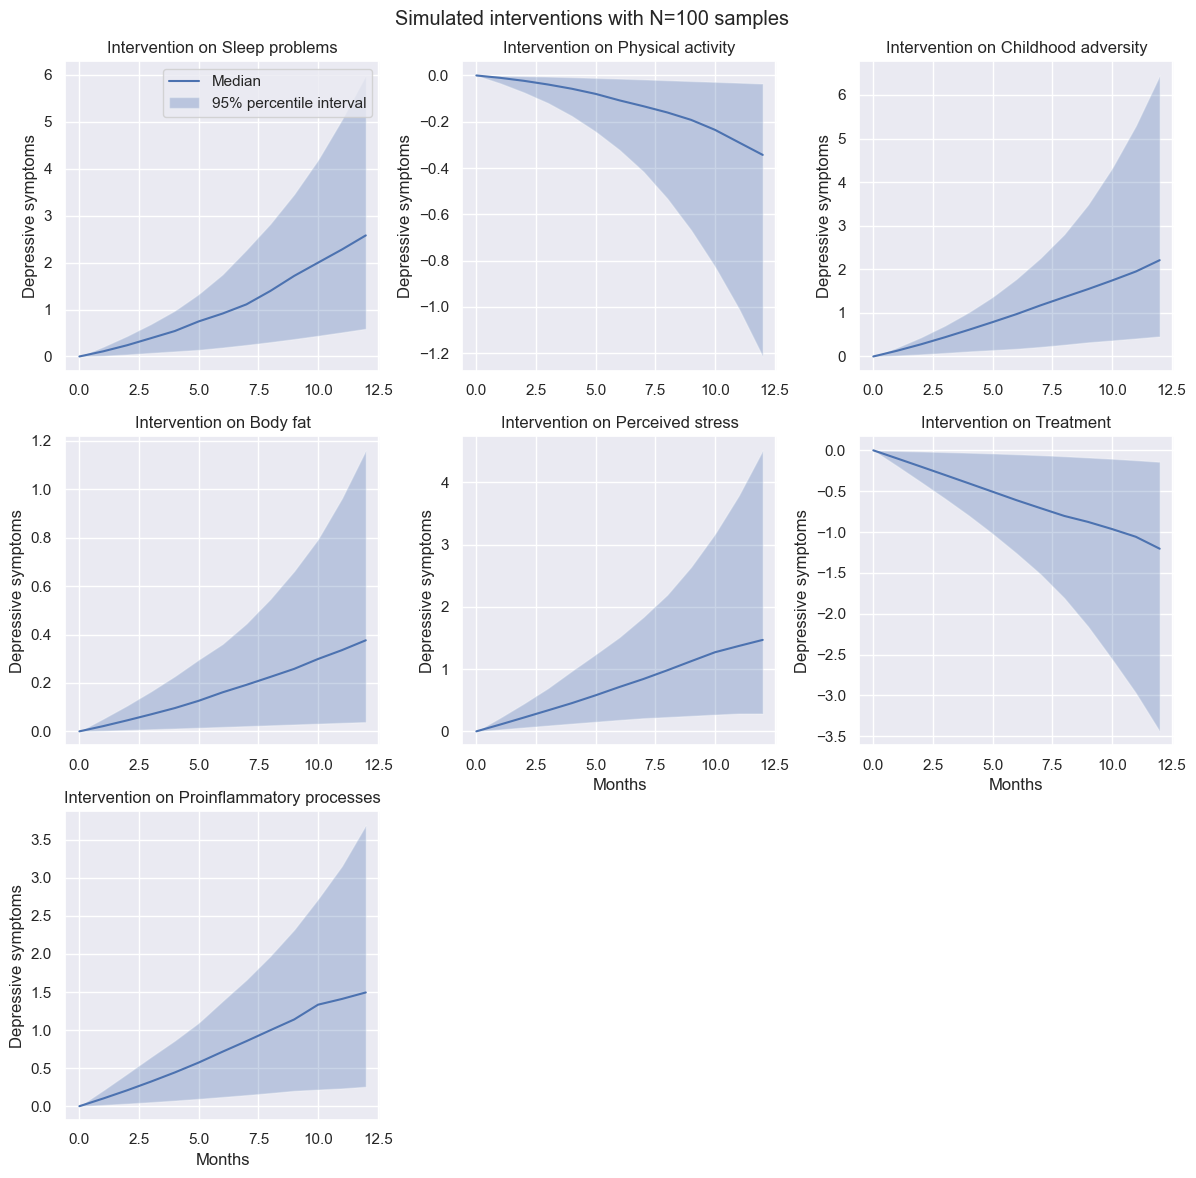

In [4]:
s.interval_type = "percentile" # "confidence", "percentile", "spaghetti"
s.confidence_bounds = .95

if s.simulate_interventions:
    plot_simulated_interventions(df_sol_per_sample, "Simulated interventions with N="+ str(s.N) + " samples", s)
else:
    plot_simulated_data(df_sol_per_sample, "Simulation data with N="+ str(s.N) + " samples", s)
    
if s.save_results:
    if s.simulate_interventions:
        title = '/simulated_interventions_plots_per_individual_N' + str(s.N) + '.jpg'
    else:
        title = '/simulated_data_plots_per_individual_N' + str(s.N) + '.jpg'

    plt.savefig("Results/" + curr_time + '_' + setting_name + 
            title,
            format='jpg', dpi=300
           )       

Intervention effect on var of interest Depressive_symptoms by:
- Sleep_problems : 2.81 +- SD: 1.48
- Childhood_adversity : 2.66 +- SD: 1.59
- Proinflammatory_processes : 1.71 +- SD: 1.05
- Perceived_stress : 1.76 +- SD: 1.23
- Body_fat : 0.47 +- SD: 0.32
- Physical_activity : -0.41 +- SD: 0.32
- Treatment : -1.3 +- SD: 0.84


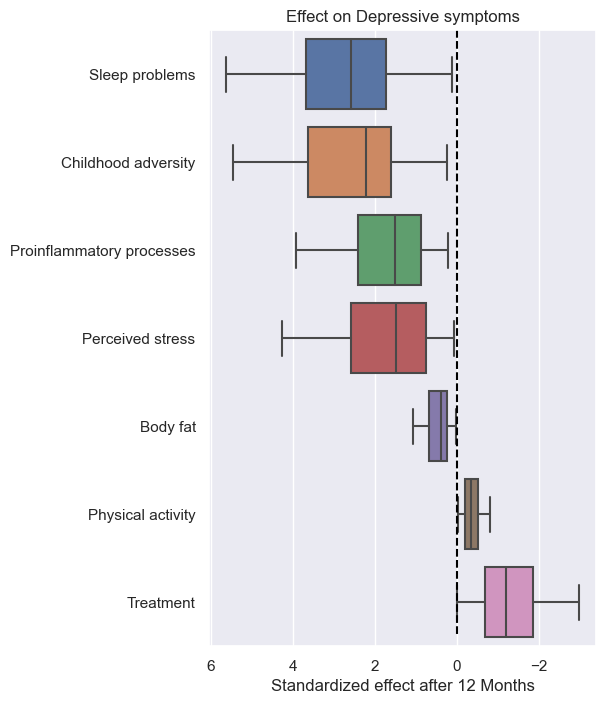

In [5]:
intervention_effects = sdm.get_intervention_effects(df_sol_per_sample)
plot_simulated_intervention_ranking(intervention_effects, s)

In [6]:
# Comparisons between interventions
interactive_plot = plot_simulated_interventions_compare(df_sol_per_sample, s)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.95, description='Interval bounds:', max=0.99, min=0.01, step=0.01), …

In [40]:
linkscore

{'Sleep_problems': {'Body_fat': -999,
  'Perceived_stress': -999,
  'Proinflammatory_processes': -999},
 'Depressive_symptoms': {'Sleep_problems': -999,
  'Childhood_adversity': -999,
  'Perceived_stress': -999,
  'Treatment': -999,
  'Proinflammatory_processes': -999},
 'Physical_activity': {'Depressive_symptoms': -999},
 'Body_fat': {'Sleep_problems': -999, 'Physical_activity': -999},
 'Perceived_stress': {'Sleep_problems': -999,
  'Depressive_symptoms': -999,
  'Childhood_adversity': -999},
 'Treatment': {'Depressive_symptoms': -999},
 'Proinflammatory_processes': {'Depressive_symptoms': -999,
  'Physical_activity': -999,
  'Body_fat': -999,
  'Perceived_stress': -999}}

In [58]:
linkscore = {t : {} for t in s.t_eval[1:]}
df_i = df_sol_per_sample[0][0]
current_t = 3

for t in s.t_eval[1:]:  # For all time steps
    linkscore[t] = {k : {g : -999 for g in params[k] if g != "Intercept"} for k in params}
    current_t = i+1
    for target in s.stocks_and_auxiliaries:  # For all stocks and auxiliaries
        target_value = df_i.loc[current_t, target]
        target_previous_value = df_i.loc[current_t-1, target]
        if target in s.stocks:
            sum_of_flows = 0
            for source in linkscore[t][target]:
                source_previous_value = df_i.loc[current_t-1, source]
                if params[target][source] > 0:  # Inflow [TODO: Ensure that also variables that only an interaction term are included here]
                    sum_of_flows += source_previous_value
                else:  # Outflow
                    sum_of_flows -= source_previous_value

            for source in linkscore[t][target]:
                source_previous_value = df_i.loc[current_t-1, source]
                if sum_of_flows == 0:
                    linkscore[t][target][source] = 0
                elif params[target][source] > 0:  # Inflow
                    linkscore[t][target][source] = -np.abs(source_previous_value/sum_of_flows)
                else:  # Outflow
                    linkscore[t][target][source] = np.abs(source_previous_value/sum_of_flows)
        
        elif target_value == target_previous_value:  # No change
            for source in linkscore[t][target]:
                linkscore[t][target][source] = 0
        
        else:  # Auxiliary
            for source in linkscore[t][target]:
                source_value = df_i.loc[current_t, source]
                source_previous_value = df_i.loc[current_t-1, source]
        
                # Determine what the value for target would have been this if only the source changed
                ## Previous value + (source value - previous source value) * parameter
                t_respect_source = target_previous_value + (source_value - source_previous_value) * params[target][source]
                delta_t_respect_to_s = t_respect_source - target_previous_value
                delta_source = source_value - source_previous_value
                sign = 1
                if delta_source != 0 and delta_t_respect_to_s != 0:
                    sign = np.sign(delta_t_respect_to_s / delta_source)

                linkscore[t][target][source] = np.abs(delta_t_respect_to_s / (target_value - target_previous_value)) * sign


In [114]:
### Obtain all loops in the model using NetworkX
import networkx as nx
import numpy as np

# Create a DiGraph from the adjacency matrix
G = nx.DiGraph(df_adj)
feedback_loops = list(nx.simple_cycles(G))

#feedback_loops = [loop for loop in feedback_loops if len(loop) > 1]  # Optional: Omit self-cycles

### For each loop, estimate the total loop score which is the multiplication of all the linkscores in the loop 
loop_scores = {}
for loop in feedback_loops:
    loop_name = ", ".join(loop)
    loop_scores[loop_name] = []
    #print(loop)
    close_loop = loop + [loop[0]]  # Add first element at the end again to close the loop
    link_scores_per_loop = []
    for t in s.t_eval[1:]:
        for i in range(len(close_loop)-1):
            assert df_adj.loc[close_loop[i], close_loop[i+1]] != 0  # There must be a link between the two nodes
            link_scores_per_loop += [linkscore[t][close_loop[i]][close_loop[i+1]]]
            #link_scores_per_loop = [linkscore[t][close_loop[i]][close_loop[i+1]] for i in range(len(close_loop)-1)]
        
        loop_score = np.prod(link_scores_per_loop)
        loop_scores[loop_name] += [loop_score]  # Loop score per time

    #print("Link scores:", link_scores_per_loop, "Loop score:", loop_score,"\n")

### Finally, normalize the loop scores by taking the loop score divided by the sum of all loop scores
normalizing_constants = [np.sum([loop_scores[ls][i] for ls in loop_scores]) for i in range(len(s.t_eval)-1)]

for i in range(len(s.t_eval)-1):
    for ls in loop_scores:
        loop_scores[ls][i] = loop_scores[ls][i] / normalizing_constants[i]

assert abs(np.mean([sum([loop_scores[ls][i] for ls in loop_scores]) for i in range(len(s.t_eval)-1)])-1) < 1e-10


In [127]:
df_loops.mean().abs() > 0.01  # PLOT ONLY THESE LOOPS

Perceived_stress, Depressive_symptoms                                                                             True
Depressive_symptoms, Treatment                                                                                    True
Sleep_problems, Body_fat                                                                                          True
Proinflammatory_processes, Depressive_symptoms                                                                    True
Sleep_problems, Proinflammatory_processes, Depressive_symptoms                                                    True
Sleep_problems, Perceived_stress                                                                                  True
Sleep_problems, Perceived_stress, Depressive_symptoms                                                             True
Sleep_problems, Proinflammatory_processes, Body_fat                                                               True
Sleep_problems, Proinflammatory_processes, Depre

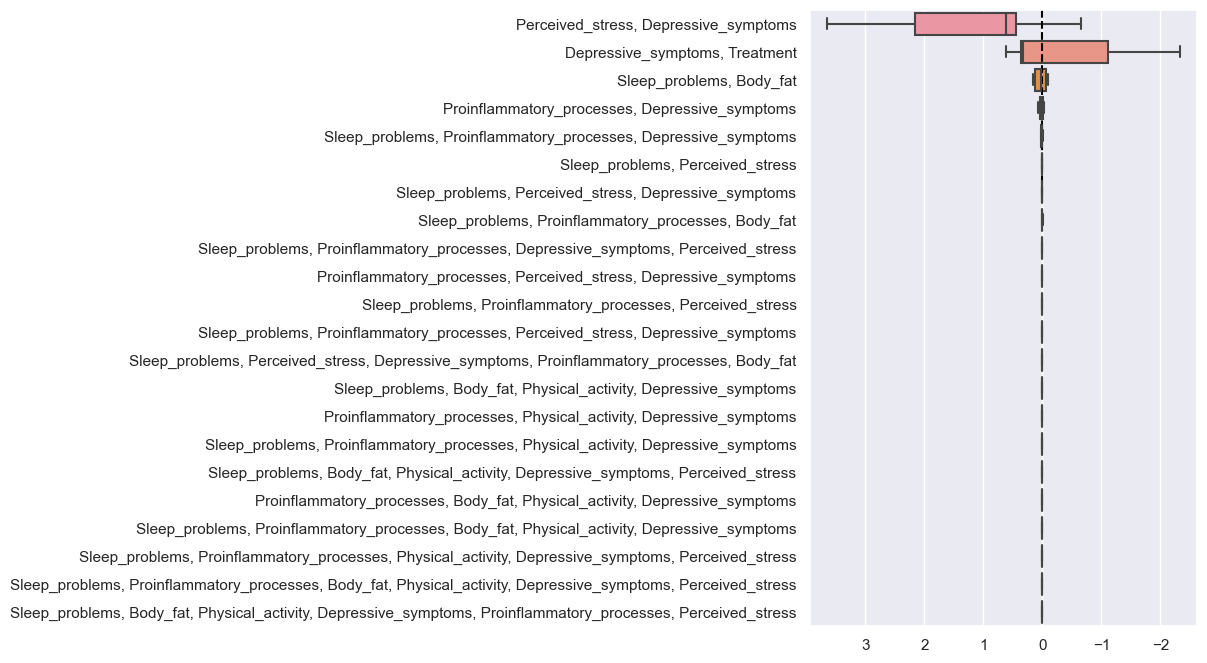

In [120]:
fig = plt.figure(figsize=(5, 8))  # 7,15
ax = fig.add_subplot(111)
df_loops = pd.DataFrame(loop_scores)

# Order by median
df_loops = df_loops.reindex(columns=list(
                    df_loops.median().sort_values(ascending=False).index))
# df_loops = df_loops.rename(mapper=dict(
#                     zip(s.intervention_variables,
#                         [" ".join(var.split("_")) for var in s.intervention_variables ])), axis=1)

sns.boxplot(data=df_loops, showfliers=False, whis=True, orient='h')
plt.vlines(x=0, ymin=-0.5, ymax=len(s.intervention_variables) -
            0.6, colors='black', linestyles='dashed')
#plt.title("Effect on " + " ".join(s.variable_of_interest.split("_")))
#plt.xlabel("Standardized effect after " + str(s.t_end) + " " + s.time_unit)
plt.ylabel("")
ax.invert_xaxis()

In [130]:
loop_scores#[ls] # Doesn't make sense this big difference

{'Sleep_problems, Body_fat': [0.4587131929787621,
  0.16486434343551312,
  0.9854452751644124,
  0.11301667416413311,
  -2.2572450362493215,
  0.06372277762964468,
  -0.29393635840453647,
  0.03392521969968299,
  -0.09851552506642139,
  0.017623933052929693,
  -0.039209023581580064,
  0.009036584124793037],
 'Sleep_problems, Body_fat, Physical_activity, Depressive_symptoms': [-0.008913869341784699,
  6.225536781300327e-05,
  -7.2311539970845155e-06,
  1.611545807789691e-08,
  6.254662375328067e-09,
  3.4311910153421068e-12,
  3.0755907088108643e-13,
  6.897995912689208e-16,
  3.8925121176291594e-17,
  1.35317250323734e-19,
  5.85007440908916e-21,
  2.6200205140925564e-23],
 'Sleep_problems, Body_fat, Physical_activity, Depressive_symptoms, Perceived_stress': [0.003477165751033697,
  9.473164133415827e-06,
  4.292249893658124e-07,
  3.731463278844004e-10,
  -5.6493634820513415e-11,
  1.2089258723837928e-14,
  -4.2270992568350073e-16,
  3.6982474582120214e-19,
  -8.140707251057596e-21,
 

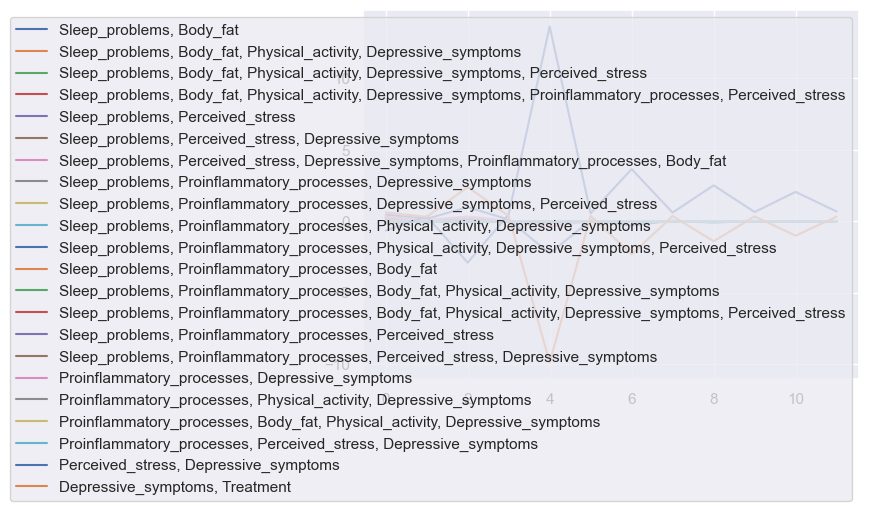

In [117]:
for ls in loop_scores:
    plt.plot(loop_scores[ls])

plt.legend(loop_scores.keys())

In [47]:

def aux_if_only_source_changed():
    # Determine what the value for target would have been if only source changed(tRespectSource). 
    # To calculate tRespectSource, we call another subroutine which is capable of recalculating target using the current value of source and 
    # the previous value of all other variables.
    
    ### Target is an auxiliary so does not depend on its previous value. 
    ### Thus, only needed to multiply the current value of the source with the model parameter in equation of target?
    return None  # curr_value_source * params[target][source]

# loop over samples
# loop over time-steps for i, t in enumerate(t_eval[1:]):

for target in s.stocks_and_auxiliaries:  # For all stocks and auxiliaries
    value = target.currentValue
    previousValue = target.previousValue
    
    if (target == stock):
        sumOfFlows = 0
        for source in target.sources:  # loop over the causes of the current variable
            if target.isInflow(source):  
                sumOfFlows += source.previousValue
            else  # is Outflow (this step is probably not needed for me)
                sumOfFlows -= source.previousValue
                
        for source in target.sources:
            if sumOfFlows == 0:
                LINKSCORE[source, target] = 0
            elif target.isInflow(source):  # Determine whether 'inflow' or outflow based on + or - of the model parameters
                LINKSCORE[source, target] = -abs(source.previousValue/sumOfFlows)
            else: 
                LINKSCORE[source, target] = abs(source.previousValue/sumOfFlows)
            
    elif value==previousValue:  # No change (probably true for constants; don't think I have to loop through those though)
        for source in target.sources:
            LINKSCORE[source, target] = 0

    else:  # Target is an auxiliary
        for source in target.sources:  # loop over the causes of the current variable
            
            tRespectSource = source.currentValue * params[target][source]  # 
            # Here we multiply the value of the source by the relevant model parameter (we dont have to account for interaction terms as these will be zero in this case).
            #aux_if_only_source_changed(target, source)  # <calc. target, use current source, prev. of rest>  
            deltaTRespectToS = tRespectSource - previousValue  # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode
            deltaSource = source.currentValue - source.previousValue
            deltaT = value - previousValue
            sign = 1
            
            if deltaSource != 0 and deltaTRespectS!= 0:
                sign = SIGN(deltaTRespectToS / deltaSource)

            LINKSCORE[source, target] = abs(deltaTRespectToS / deltaT) * sign   # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode

            
            

SyntaxError: expected ':' (1804982119.py, line 22)

In [ ]:
#### Implement Loops That Matter (Pseudoalgorithm provided in link below)
#### https://onlinelibrary.wiley.com/doi/full/10.1002/sdr.1658
### From the paper:
##"" The computation of the link and loop score metrics, nonetheless, does require that equations be computed multiple times per dt, 
# and this cannot bedone in standard software. For this article, we have modified an open sourceand publicly available simulation engine sd.js (Powers, 2019) 
# to simulate themodel and perform the link and loop score calculations. The pseudo code for this computation is shown below in Figure 1. 
# Figure 1 shows how we walk
# through all the variables in the model calculating the link scores for all links coming in to each variable. 
# First, for each variable (target), we check whether it is a stock or not. If the target is a stock,
# then we directly apply Eqn 2 to determine the link score from each flow (source) into the target. 
# If target is not a stock, we apply Eqn 1. When applying Eqn 1 for each source/target combination, 
# the first thing we do is determine what the value for target would have been if only source changed(tRespectSource). 
# To calculate tRespectSource, we call another subroutine which is capable of recalculating target using the current value of source and 
# the previous value of all other variables. Using tRespectSource, we determine the partial change in target with respect to source(del-taTRespectS). 
# The change in source and target are straightforward calculations using the current and previous values of target and source. Finally, we
# calculate the sign, making sure we do not produce a divide by zero, and then the link score, using the already calculated values. ""

# If A --> B, then A is a source and B is a target.

def aux_if_only_source_changed():
    # Determine what the value for target would have been if only source changed(tRespectSource). 
    # To calculate tRespectSource, we call another subroutine which is capable of recalculating target using the current value of source and 
    # the previous value of all other variables.
    
    ### Target is an auxiliary so does not depend on its previous value. 
    ### Thus, only needed to multiply the current value of the source with the model parameter in equation of target?
    return None  # curr_value_source * params[target][source]


## I THINK I CAN JUST RUN THROUGH THIS ROUTINE WITH A MATRIX OF PREDICTED VALUES

for target in variables:  # For all stocks and auxiliaries
    value = target.currentValue
    previousValue = target.previousValue
    
    if (target == stock):
        sumOfFlows = 0
        for source in target.sources:  # loop over the causes of the current variable
            if target.isInflow(source):  
                sumOfFlows += source.previousValue
            else  # is Outflow (this step is probably not needed for me)
                sumOfFlows -= source.previousValue
                
        for source in target.sources:
            if sumOfFlows == 0:
                LINKSCORE[source, target] = 0
            elif target.isInflow(source):  # Determine whether 'inflow' or outflow based on + or - of the model parameters
                LINKSCORE[source, target] = -abs(source.previousValue/sumOfFlows)
            else: 
                LINKSCORE[source, target] = abs(source.previousValue/sumOfFlows)
            
    elif value==previousValue:  # No change (probably true for constants; don't think I have to loop through those though)
        for source in target.sources:
            LINKSCORE[source, target] = 0

    else:  # Target is an auxiliary
        for source in target.sources:  # loop over the causes of the current variable
            tRespectSource = source.currentValue * params[target][source]  
            # Here we multiply the value of the source by the relevant model parameter (we dont have to account for interaction terms as these will be zero in this case).
            #aux_if_only_source_changed(target, source)  # <calc. target, use current source, prev. of rest>  
            deltaTRespectToS = tRespectSource - previousValue  # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode
            deltaSource = source.currentValue - source.previousValue
            deltaT = value - previousValue
            sign = 1
            
            if deltaSource != 0 and deltaTRespectS!= 0:
                sign = SIGN(deltaTRespectToS / deltaSource)

            LINKSCORE[source, target] = abs(deltaTRespectToS / deltaT) * sign   # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode

            
            
### Once we have the link scores we have to loop over all possible loops and assign them a Loop score
## First get all the loops based on adjacency matrix. Then we multiply all the link scores of the links in each loop.

Copilot wrote: Please note that you’ll need to define the calculate_target_using_current_source_previous_of_rest function according to your specific requirements. Also, model.variables, target.currentValue, target.previousValue, target.isStock, target.sources, target.isInflow(source), source.previousValue, source.currentSign, and source.previousSign are placeholders and you’ll need to replace them with your actual data or methods. This code is a direct translation of your pseudocode and might need adjustments based on your actual data structures and requirements.

In [ ]:
import numpy as np

# Initialize LINKSCORE as a dictionary
LINKSCORE = {}

# Function to calculate target using current source and previous of rest
def calculate_target_using_current_source_previous_of_rest(target, currentValue, previousValue, source):
    # Add your implementation here
    pass

# Iterating through each target in model variables
for target in model.variables:
    # Getting current and previous values of the target
    currentValue = target.currentValue
    previousValue = target.previousValue

    # Checking if the target is a stock
    if target.isStock:
        sumOfFlows = 0
        
        # Calculating sum of flows from all sources connected to this stock
        for source in target.sources:
            if target.isInflow(source):
                sumOfFlows += source.previousValue
            else:
                sumOfFlows -= source.previousValue
        
        # Updating link scores based on calculated sum of flows 
        for source in target.sources:
            if sumOfFlows == 0:
                LINKSCORE[source, target] = 0
            elif not isInflow(source):
                LINKSCORE[source, target] = -abs(source.previousValue / sumOfFlows)
            else:
                LINKSCORE[source, target] = abs(source.previousValue / sumOfFlows)
    
    # If value remains constant, setting link score to zero 
    elif currentValue == previousValue:  
        for source in target.sources:  
            LINKSCORE[source,target] = 0
    
    # If there's a change in value, updating link score accordingly 
    else:  
        for source in targets.sources:  
            
            tRespectSource = calculate_target_using_current_source_previous_of_rest(target,
                                                                                   currentValue,
                                                                                   previousValue,
                                                                                   source)
            
            deltaTRespectS = tRespectSource - previousValue
            
            deltaSource = source.currentSign - source.previousSign
            
            deltaT= currentValue - previousValue
            
            sign=1
            
             # Calculating sign based on deltas 
             if deltaSource != 0 and deltaTRespectS != 0:   
                 sign= np.sign(deltaTRespectToS/deltaSource) 
            
             LINKSCORE[source,target]= abs(deltaTRespects/deltaT)*sign;


In [ ]:
### Stability analysis
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint

def stability_analysis(A, b=[0]):
    # If b is provided, transform the system
    if np.all(b==0):  # The system is homogenous
        equilibrium = np.zeros(np.size(b))
    else:  # The system is not homogenous
        equilibrium = -np.matmul(np.linalg.inv(A), b)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Check stability
    stability = all(np.real(eigenvalue) < 0 for eigenvalue in eigenvalues)

    return stability, equilibrium, eigenvalues, eigenvectors

# Define A and b
A = np.array([[1, 2], [3, 4]])
b = np.array([0, 0]) # np.array([5, 6])

# Perform stability analysis
stability, equilibrium, eigenvalues, eigenvectors = stability_analysis(A, b)

print(f"The system is stability: {stability}")
print(f"At equilibrium point:  {equilibrium}")
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors: {eigenvectors}")




# Define the system of ODEs
def system(x, t, A, K, b):
    return np.matmul(A, x) + np.matmul(Kx, x) + b

# Define the Jacobian of the system
##def jacobian(x, A, K):
    return A + 2 * K.dot(np.outer(x, np.eye(len(x))))

b = np.ones([3])
# Find the equilibrium point
x_star = fsolve(lambda x: system(x, 0, A, K, b), np.zeros([3]))

# Compute the Jacobian at the equilibrium point
J = A + 2 * np.matmul(K, x_star)
print("Jacobian matrix at the equilibrium point is:")

stability, notrelevant, eigenvalues, eigenvectors = stability_analysis(J, b)

print(f"The system is stability: {stability}")
print(f"At equilibrium point:  {x_star}")
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors: {eigenvectors}")

